# This is a Jupyter notebook for David Dobrinskiy's HSE Thesis
## How Venture Capital Affects Startups' Success


In [1]:
# You should be running python3

import sys
print(sys.version)

3.4.4 |Anaconda 2.3.0 (64-bit)| (default, Jan 11 2016, 13:54:01) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [21]:
import pandas as pd  # http://pandas.pydata.org/
import numpy as np   # http://numpy.org/

import statsmodels.api as sm  # http://statsmodels.sourceforge.net/stable/index.html
import statsmodels.formula.api as smf
import statsmodels as stmod

print("Pandas Version: {}".format(pd.__version__))          # pandas version
print("StatsModels Version: {}".format(stmod.__version__))  # StatsModels version

Pandas Version: 0.14.1
StatsModels Version: 0.6.1


### Let us look at the dynamics of total US VC investment

In [3]:
# load the pwc dataset from azure

from azureml import Workspace

ws = Workspace()
ds = ws.datasets['pwc_moneytree.csv']
frame = ds.to_dataframe()

In [4]:
frame.head()

,Quarter,Unnamed: 1,1,2,3,4,Grand Total
0,1995,# of Deals,503,466,434,494,"1,897"
1,NaN,Amount Invested,"$1,690,040,500","$2,546,374,500","$1,709,754,500","$2,070,353,900","$8,016,523,400"
2,1996,# of Deals,585,671,604,775,"2,635"
3,NaN,Amount Invested,"$2,437,964,900","$3,017,298,000","$2,606,841,300","$3,223,318,800","$11,285,423,000"
4,1997,# of Deals,773,778,762,919,"3,232"


In [5]:
del frame['Grand Total']
frame.columns = ['year', 'type', 'q1', 'q2', 'q3', 'q4']
frame['year'] = frame['year'].fillna(method='ffill')
frame.head()

,year,type,q1,q2,q3,q4
0,1995,# of Deals,503,466,434,494
1,1995,Amount Invested,"$1,690,040,500","$2,546,374,500","$1,709,754,500","$2,070,353,900"
2,1996,# of Deals,585,671,604,775
3,1996,Amount Invested,"$2,437,964,900","$3,017,298,000","$2,606,841,300","$3,223,318,800"
4,1997,# of Deals,773,778,762,919


Deals and investments are in alternating rows of **frame**, let's separate them

In [6]:
      deals_df = frame.iloc[0::2]
investments_df = frame.iloc[1::2]

In [7]:
# once separated, 'type' field is identical within each df
# let's delete it

del       deals_df['type']
del investments_df['type']

In [8]:
deals_df.head()

,year,q1,q2,q3,q4
0,1995,503,466,434,494
2,1996,585,671,604,775
4,1997,773,778,762,919
6,1998,871,912,931,"1,030"
8,1999,936,"1,330","1,448","1,892"


In [9]:
investments_df.head()

,year,q1,q2,q3,q4
1,1995,"$1,690,040,500","$2,546,374,500","$1,709,754,500","$2,070,353,900"
3,1996,"$2,437,964,900","$3,017,298,000","$2,606,841,300","$3,223,318,800"
5,1997,"$3,104,430,200","$3,691,566,400","$3,775,959,100","$4,499,598,900"
7,1998,"$4,199,545,200","$5,784,400,500","$5,412,295,700","$6,165,090,000"
9,1999,"$6,648,622,700","$11,315,434,200","$13,654,453,100","$23,340,087,500"


In [10]:
def unstack_to_series(df):
    """
    Takes q1-q4 in a dataframe and converts it to a series
    
    input: a dataframe containing ['q1', 'q2', 'q3', 'q4']
    
    ouput: a pandas series
    """
    quarters = ['q1', 'q2', 'q3', 'q4']
    d = dict()
    for i, row in df.iterrows():
        for q in quarters:
            key = str(int(row['year'])) + q
            d[key] = row[q]

            # print(key, q, row[q])
    return pd.Series(d)

In [11]:
      deals = unstack_to_series(deals_df      ).dropna()
investments = unstack_to_series(investments_df).dropna()

In [12]:
def string_to_int(money_string):
    numerals = [c if c.isnumeric() else '' for c in money_string]
    return int(''.join(numerals))

In [13]:
# convert deals from string to integers
deals = deals.apply(string_to_int)
deals.tail()

2015q3    1189
2015q4    1047
2016q1    1021
2016q2     999
2016q3     891
dtype: int64

In [14]:
# investment in billions USD
# converts to integers - which is ok, since data is in dollars
investments_b = investments.apply(string_to_int) 
# in python3 division automatically converts numbers to floats, we don't loose precicion
investments_b = investments_b / 10**9
# round data to 2 decimals
investments_b = investments_b.apply(round, ndigits=2)
investments_b.tail()

2015q3    16.71
2015q4    12.34
2016q1    12.64
2016q2    15.57
2016q3    10.63
dtype: float64

### Plot data from MoneyTree report

http://www.pwcmoneytree.com

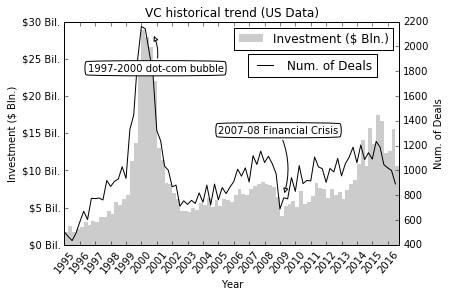

In [15]:
import matplotlib.pyplot  as plt  # http://matplotlib.org/
import matplotlib.patches as mpatches
import matplotlib.ticker  as ticker
%matplotlib inline

# change matplotlib inline display size
# import matplotlib.pylab as pylab
# pylab.rcParams['figure.figsize'] = (12, 8)  # that's default image size for this interactive session

fig, ax1 = plt.subplots()
ax1.set_title("VC historical trend (US Data)")
t = range(len(investments_b))      # need to substitute tickers for years later
width = t[1]-t[0]
y1 = investments_b

# create filled step chart for investment amount
ax1.bar(t, y1, width=width, facecolor='0.80', edgecolor='', label = 'Investment ($ Bln.)')
ax1.set_ylabel('Investment ($ Bln.)')

# set up xlabels with years
years = [str(year)[:-2] for year in deals.index][::4]  # get years without quarter 
ax1.set_xticks(t[::4])                   # set 1 tick per year
ax1.set_xticklabels(years, rotation=50)  # set tick names
ax1.set_xlabel('Year')                   # name X axis

# format Y1 tickers to $ billions
formatter = ticker.FormatStrFormatter('$%1.0f Bil.')
ax1.yaxis.set_major_formatter(formatter)
for tick in ax1.yaxis.get_major_ticks():
    tick.label1On = False
    tick.label2On = True

# create second Y2 axis for Num of Deals
ax2 = ax1.twinx()
y2 = deals
ax2.plot(t, y2, color = 'k', ls = '-', label = 'Num. of Deals')
ax2.set_ylabel('Num. of Deals')

# add annotation bubbles
ax2.annotate('1997-2000 dot-com bubble', xy=(23, 2100), xytext=(6, 1800),
                bbox=dict(boxstyle="round4", fc="w"),
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3,rad=0.2",
                                fc="w"),
            )

ax2.annotate('2007-08 Financial Crisis', xy=(57, 800), xytext=(40, 1300),
                bbox=dict(boxstyle="round4", fc="w"),
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3,rad=-0.2",
                                fc="w"), 
            )


# add legend
ax1.legend(loc="best")
ax2.legend(bbox_to_anchor=(0.95, 0.88))

plt.show()

In [22]:
# import dataset ...